# Optimal and Adaptive Control Project, Part 1: Constrained LQR

In this part of the project, we will explore the Linear Quadratic Regulator (LQR) and how it works. We will then explore how to solve the LQR problem with additional constraints on our system. For a detailed introduction to the project, please refer to the supporting document.

As a refresher, the LQR problem is 
$$min_{\mathbf{u}_0,...,\mathbf{u}_{N-1}} \: \: \mathbf{x}_N^TQ\mathbf{x}_N + \sum_{k=0}^{N-1}{\mathbf{x}_k^TQ\mathbf{x}_k + \mathbf{u}_k^TR\mathbf{u}_k}$$

$$s.t. \: \: \mathbf{x}_{k+1} = A\mathbf{x}_{k} + B\mathbf{u}_{k}, \: \: k = 0,...N-1$$

$$\mathbf{x}_0 = \mathbf{x}_{init}$$

This can be solved using the discrete-time, finite time horizon Algebraic Riccati Equation. We have provided code for this below. 

In [2]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def simulate_system(A, B, x, u):
    '''
    Give the next state according to the system dynamics, given the current
    state x.
    '''
    return A @ x + B @ u

def optimal_control(A, B, Q, R, x0, N):
    '''
    Solve the LQR problem using the Discrete time Algebraic Riccati Equations
    for the given system (given by A, B) and the given Q and R. x0 is the 
    initial state and N is the time horizon under 0-indexing.
    '''
    
    R = np.eye(2) * R 
    B = np.array([[B[0], 0], [B[1], 0]])
    
    # Go backwards in time to generate all of the P matrices.
    Pk = [Q]
    for i in range(N-1):
        BPBR_inv = np.linalg.inv(B.T @ Pk[i] @ B + R)
        Pk.append(Q + A.T @ Pk[i] @ A -
                  A.T @ Pk[i] @ B @ BPBR_inv @ B.T @ Pk[i] @ A)
    Pk.reverse()
    
    # Now go forwards in time to generate the optimal control inputs.
    # This also gives us the resulting states from applying the controls.
    uk = []
    xk = [x0]
    for i in range(N):
        BPBR_inv = np.linalg.inv(B.T @ Pk[i] @ B + R)
        uk.append(-BPBR_inv @ B.T @ Pk[i] @ A @ xk[i])
        xk.append(simulate_system(A, B, xk[i], uk[i]))

    return [elem[0] for elem in uk], xk

For this part of the project, we will work with the lateral dynamics of a quadrotor:

<img src="quadrotor_lateral_dynamics.png" width="500"/>

The dynamics for this system are given by $$\ddot{x}(t) = gtan(\theta)$$ where $g$ is the acceleration due to gravity and $x(t)$ is the position along the force vector $T$. Linearizing this model, we have $$\ddot{x}(t) = g\theta$$ Then, the continuous time model is 

$$\begin{bmatrix} \dot{x} \\ \ddot{x} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} 
\begin{bmatrix} x \\ \dot{x} \end{bmatrix} + \begin{bmatrix} 0 \\ g \end{bmatrix}u$$ where $u = \theta$.

Discretizing for a sampling time of 0.1 sec, the system dynamics become
$$x_{k + 1} = \begin{bmatrix} 1 & 0.1\\ 0 & 1 \end{bmatrix}x_k + 9.8\begin{bmatrix} 0.005 \\ 0.1 \end{bmatrix}u_k$$
$$x_0 = \begin{bmatrix} 5 \\ 5 \end{bmatrix}$$

See [1] for more information about this model and its derivation.

We will start with $$Q = \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}$$ and 
$$R = 1$$ 
Throughout this notebook, we will keep $Q$ and $R$ in this same format: $Q = qI$ and $R = r$, for $q, r \geq 0$. 
$N$ will be 60 seconds. 

In [55]:
A = np.array([[1, 0.1],
              [0, 1]])
B = 9.8 * np.array([0.005, 0.1])

q = 1
r = 1
Q = np.eye(2) * q
R = r
x0 = np.array([5, 5])

N = 60

### Question 1
With this $A$, $B$, $Q$, and $R$ and the provided code implementing the DARE, generate plots of the system response. That is, use the DARE to find the optimal controller for the system. Then, plot each component of the resulting state and control over time. (That is, your x-axis should be time and you should plot u, x[0], and x[1] as they vary over time).

Text(0, 0.5, 'position')

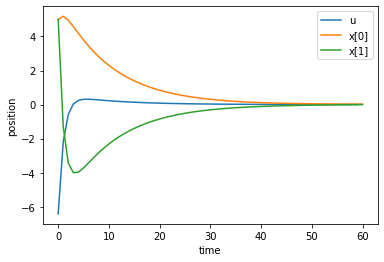

In [5]:
# Call optimal_control() here
# Plot the resulting controls and states
uk, xk = optimal_control(A, B, Q, R, x0, N)
plt.plot(uk,label='u')
plt.plot(np.array(xk)[:,0],label='x[0]')
plt.plot(np.array(xk)[:,1],label='x[1]')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')

### Question 2
In the above, we set both of our $q$ and $r$ values to 1. But remember that these values are set by the control engineer to get a desired system response. What happens if these values are different? Play around with some different values of $q$ and $r$ and plot the system responses below.

In [6]:
q = 0.01 # Change this value
r = 1 # Change this value
Q = np.eye(2) * q
R = r

Text(0, 0.5, 'position')

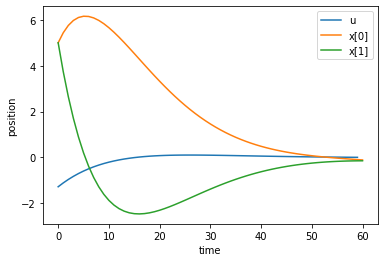

In [7]:
# Call optimal_control() here
# Plot the resulting controls and states
uk_1, xk_1 = optimal_control(A, B, Q, R, x0, N)
plt.plot(uk_1,label='u')
plt.plot(np.array(xk_1)[:,0],label='x[0]')
plt.plot(np.array(xk_1)[:,1],label='x[1]')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')

### Question 3
Now we will tune the values of $q$ and $r$ in specific ways such that our LQR problem can account for constraints. Consider the case in which the control input at each time step is constrained to have a magnitude less than or equal to 1.5. What values of $q$ and $r$ give you the appropriate $u$'s? Plot the system response and show that your $u$'s fulfill the constraint.

1.2829886198471732


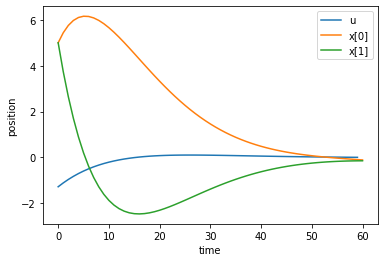

In [8]:
q = 0.1 # Change this value
r = 10 # Change this value
Q = np.eye(2) * q
R = r

# Call optimal_control() here
uk, xk = optimal_control(A, B, Q, R, x0, N)
plt.plot(uk_1,label='u')
plt.plot(np.array(xk_1)[:,0],label='x[0]')
plt.plot(np.array(xk_1)[:,1],label='x[1]')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')
# Plot the resulting controls and states

# Check that your uk satisfies the constraint
print(max(np.abs(uk)))

### Question 4
Now, let us use the alternate approach to solving the LQR problem: treating it as a quadratic program. First, formulate your optimization problem. Then, use the cvxpy library to solve for the optimal controller. 

In [9]:
# Setting q and r back to the original values in order to focus just on the cvxpy constraint
q = 1
r = 1
Q = np.eye(2) * q
R = r

In [98]:
# Write your xk's as:
xk = cp.Variable(2)
state = [xk]

# Remember your constraints can include expressions such as
# xkplus1 == A @ xk + B * uk
# This time, your constraints should include the constraint on uk
constraints = [xk == np.array([5,5])]

# Then generate a cost function
cost = 0

# Your code here
controls = []
for i in range(60):
    # and your uk's as:
    uk = cp.Variable()
    xk_1 = cp.Variable(2)
    controls.append(uk)
    state.append(xk_1)
    constraints.append(xk_1 == A*xk + B * uk ) 
    cost += q*cp.norm(xk)**2 + r*cp.norm(uk)**2 
    xk = xk_1

objective = cp.Minimize(cost)
prob = cp.Problem(objective, constraints)
soln_opt = prob.solve()
print(soln_opt)

390.5513002903703


Plot the system response. As a sanity check, your solution should be very similar to the solution generated by the DARE when $q$ and $r$ are both 1.

Text(0, 0.5, 'position')

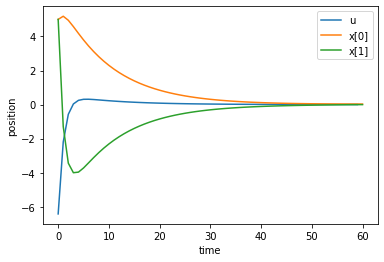

In [99]:
# Your code here
xk = np.array(list(map( lambda x: x.value, state)))
uk = np.array(list(map( lambda x: x.value, controls)))

plt.plot(uk,label='u')
plt.plot(xk[:,0], label='x[0]')
plt.plot(xk[:,1],label='x[1]')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')

# Plot uk and each element of xk

### Question 5
Tuning $q$ and $r$ values, as we did in Question 3, is a "soft" way to enforce constraints. However, it is difficult to incorporate hard constraints in the Discrete Algebraic Riccatti Equation approach. This is where your cvxpy implementation comes in! Use cvxpy's constraint functionality to incorporate the above constraint on the control input into your quadratic program. What does the system response look like? As a reminder, the constraint is that the control input at each time step must have magnitude <= 1.5.

In [110]:
# Write your xk's as:
xk = cp.Variable(2)
state = [xk]

# Remember your constraints can include expressions such as
# xkplus1 == A @ xk + B * uk
# This time, your constraints should include the constraint on uk
constraints = [xk == np.array([5,5])]

# Then generate a cost function
cost = 0

# Your code here
controls = []
for i in range(60):
    # and your uk's as:
    uk = cp.Variable()
    xk_1 = cp.Variable(2)
    controls.append(uk)
    state.append(xk_1)
    constraints.append(xk_1 == A*xk + B * uk ) 
    constraints.append(uk <= 1.5)   
    constraints.append(uk >= -1.5) 
    cost += q*cp.norm(xk)**2 + r*cp.norm(uk)**2 
    xk = xk_1

objective = cp.Minimize(cost)
prob = cp.Problem(objective, constraints)
soln_opt = prob.solve()
print(soln_opt)

560.3325697850361


1.5000000040654407


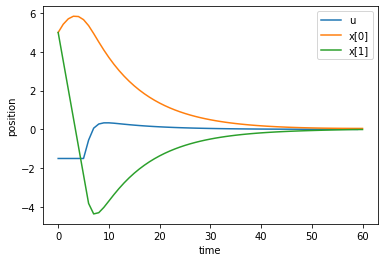

In [113]:
# Your code here

xk = np.array(list(map( lambda x: x.value, state)))
uk = np.array(list(map( lambda x: x.value, controls)))

plt.plot(uk,label='u')
plt.plot(xk[:,0], label='x[0]')
plt.plot(xk[:,1],label='x[1]')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')

# Check that your uk satisfies the constraint
print(max(np.abs(uk)))

### Question 6
Finally, think about the similarities and differences between the two approaches you implemented to run constrained LQR (tuning values versus having constraints in a quadratic program). Which system response is smoother and which is jerkier? Which approach might be better to use in safety-critical applications? 

#### Tuning is less jerkier than having an additional constraint on uk in the quadratic program. The convergens of xk is faster in the quadratic program than than tuning values of Q, and R, thus resulting in a jerkier response. In a safety-critical applicaiton, it is better to tune the values of Q and R rather than adding additional constraints into the QP 

### Bibliography

1. Patrick Bouffard, "On-board Model Predictive Control of a Quadrotor Helicopter: Design, Implementation, and Experiments", Dec 2012, http://www.eecs.berkeley.edu/Pubs/TechRpts/2012/EECS-2012-241.html. 